In [1]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Fourier transform/PCA-SVD-Autoencoder-Fourier-Wavelet-Transformation-for-denoising/'

In [ ]:
# if not os.path.exists(path):
#   !git clone https://github.com/Tangshengku/PCA-SVD-Autoencoder-Fourier-Wavelet-Transformation-for-denoising
# else:
#   print("data and path already exists!")

# 가우시안 필터링 처리
   - 영상의 세세한 부분을 제거하여 부드럽게 한다는 뜻으로, 스무딩 처리(Smoothing Processing)라고도 한다
   - σ 값이 작을수록 적은 저주파 성분만 통과시킵니다.
   - σ 값이 클수록 높이는 낮지만 폭은 넓어지므로 많은 저주파 성분을 통과시킵니다.
   - 즉, 이렇게 σ 값을 조절하여 고주파량과 저주파량을 조절할 수 있는 것이 가우시안 필터링의 핵심입니다.

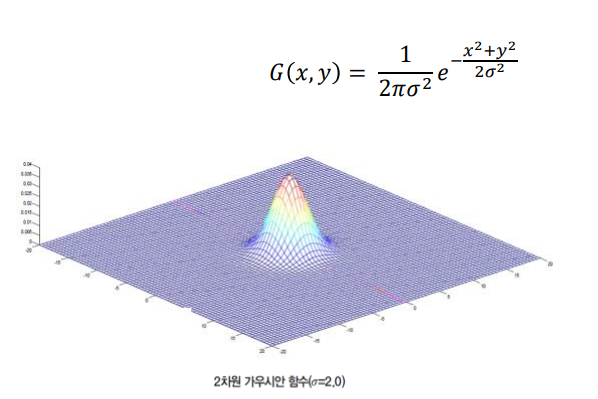



# Butterworth  필터링
  - 버터 워스 필터는 통과 대역에서 가능한 한 평탄한 주파수 응답을 갖도록 설계된 신호 처리 필터 유형
  - Butterworth 필터의 장점은 부드럽고 단조롭게 감소하는
  - Butterworth 필터의 차단 주파수를 지정한 후 전환의 가파른 정도는 필터 차수에 비례
  - 고차 Butterworth 필터는 이상적인 저역 통과 필터와 유사

  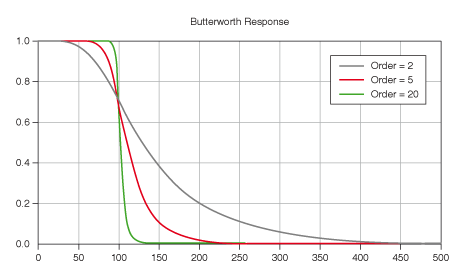

  - 이상적인  필터

  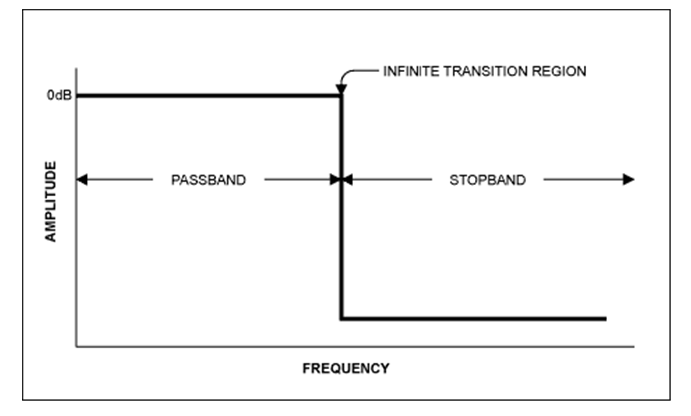

# 최대 신호 대 잡음비 ((Peak Signal-to-noise ratio, PSNR)
- 신호가 가질 수 있는 최대 전력에 대한 잡음의 전력을 나타낸 것이다. 주로 영상 또는 동영상 손실 압축에서 화질 손실 정보를 평가할때 사용된다.
- 최대 신호 대 잡음비는 신호의 전력에 대한 고려 없이 평균 제곱 오차(MSE)를 이용해서 계산 할 수 있다.
- 손실이 적을수록 높은 값을 가진다. 무손실 영상의 경우에는 MSE가 0이기 때문에 PSNR은 정의되지 않는다.

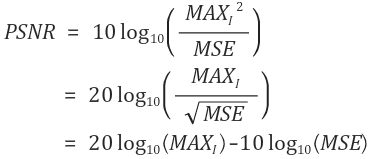

# Fourier 

26.18334375278069
25.896785260865393
24.117102122285218


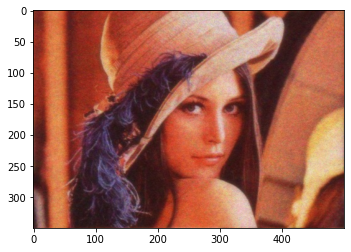

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

#Gaussian 저역 통과 필터 (이미지를 흐리게 하거나 노이즈를 줄이는 것에 많이 사용)
def gaussian_make_transform(d,image_size):
    trans_matrix=np.zeros(image_size)
    center_point = tuple(map(lambda x: (x - 1) / 2, trans_matrix.shape))
    for i in range(trans_matrix.shape[0]):
        for j in range(trans_matrix.shape[1]):
            dis=math.sqrt((center_point[0]-i)**2+(center_point[1]-j)**2)
            trans_matrix[i,j]=np.exp(-(dis**2)/(2*(d**2)))
    return  trans_matrix

def gaussian_low_fiter(image,d):
    D=gaussian_make_transform(d,image.shape)
    image_fft = np.fft.fft2(image)
    image_shift = np.fft.fftshift(image_fft)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(image_shift * D)))
    return new_img

#butterworth 저역 통과 필터 (통과대역에서 아무런 리플(ripple)도 발생 시키지 않으며, 이대역 밖의 원하지 않는 주파수는 감쇠시킴)
def butterworth_make_transform(d,image_size,n):
    trans_matrix = np.zeros(image_size)
    center_point = tuple(map(lambda x: (x - 1) / 2, trans_matrix.shape))
    for i in range(trans_matrix.shape[0]):
        for j in range(trans_matrix.shape[1]):
            dis = math.sqrt((center_point[0] - i) ** 2 + (center_point[1] - j) ** 2)
            trans_matrix[i, j] = 1-1/((1+(d/dis))**n)
    return trans_matrix

def butterworth_low_filter(image,d,n):
    D = butterworth_make_transform(d, image.shape,n)
    image_fft = np.fft.fft2(image)
    image_shift = np.fft.fftshift(image_fft)
    new_img = np.abs(np.fft.ifft2(np.fft.ifftshift(image_shift * D)))
    return new_img

#PSNR 최고 신호 대 잡음비 (Peak Signal-to-noise ratio)
def psnr2(img1, img2):
  mse = np.mean( (img1/255. - img2/255.) ** 2 )
  if mse < 1.0e-10:
      return 100
  PIXEL_MAX = 1
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

image=cv2.imread( data_path + "noisedimages/Lena.jpg") #노이즈 있는 이미지 파일 읽음
image_original=cv2.imread(data_path + "OriginalImages/Lena.jpg") # 화질 좋은 이미지 파일 읽음
b,g,r=cv2.split(image) #RGB 색상 평면을 나눔
# b=gaussian_low_fiter(b/1.0,25)
# g=gaussian_low_fiter(g/1.0,25)
# r=gaussian_low_fiter(r/1.0,25)
b=butterworth_low_filter(b/1.0,20,2)
g=butterworth_low_filter(g/1.0,20,2)
r=butterworth_low_filter(r/1.0,20,2)
image_plt=cv2.merge([r,g,b])
image_cv=cv2.merge([b,g,r]) #cv채널 구성은 plt와 반대입니다.
for i in range(image.shape[2]):
    print(psnr2(image_cv[:,:,i],image_original[:,:,i]))
plt.imshow(image_plt/255)
plt.show()

# PCA
- 차원 축소를 Noise Reduction 및 Filtering 기술로 활용 가능
- 데이터 세트 내의 잡은 데이터 내의 변동의 큰 성분을 포함하지 않으므로, 작은 변동 성분을 제거한 다음 데이터를 원래 데이터 공간으로 복원하면, 데이터에서 불필요한 노이즈 제거 가능

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


24.93821547227202
25.119597560109757
23.904304995798658


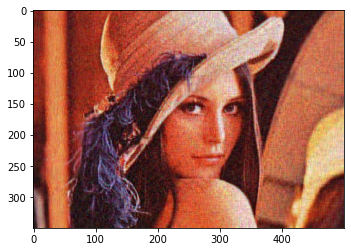

False

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2
import math

img = cv2.imread(data_path + "noisedimages/Lena.jpg",1)
img1 = cv2.imread(data_path + "OriginalImages/Lena.jpg",1)#PSNR 계산 용 원본 이미지 
b, g, r = cv2.split(img);#그림의 B, R, G 색상 채널 분리

#PSNR 계산 (최대 신호 대 잡음비 (Peak Signal-to-noise ratio))
def PSNR(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
# 소음이 많으면 정보를 적게 유지
# 다음 코드는 보유 된 정보의 가장 좋은 비율을 찾습니다.
"""a = np.zeros(shape=(500,1))
i=0.5
num=0
while(i<1):
   pca = PCA(i)  
   pca.fit(r)
   r2 = pca.transform(r)  # r_low 데이터를 얻기 위해 데이터 r의 차원을 줄입니다.
   r_de = pca.inverse_transform(r2).astype(np.int)  # 데이터를 원래 차원으로 업그레이드
   pca.fit(g)
   g2 = pca.transform(g)
   g_de = pca.inverse_transform(g2).astype(np.int)
   pca.fit(b)
   b2 = pca.fit_transform(b)
   b_de = pca.inverse_transform(b2).astype(np.int)
   img2 = cv2.merge([b_de, g_de, r_de])
   a[num]=PSNR(img2, img1)
   i+=0.005
   num+=1
print(np.argsort(-a,axis=0))"""

pca = PCA(0.875) #주성분을 몇 개로 할지
pca.fit(r) #r의 주성분을 찾음
r2 = pca.transform(r)  # 데이터 r_2를 얻기 위해 데이터 r의 차원을 줄입니다. 새로운 주성분으로 데이터 변환
r_de = pca.inverse_transform(r2).astype(np.int)  # 데이터를 원래 차원으로 업그레이드
pca.fit(g)
g2 = pca.transform(g)
g_de = pca.inverse_transform(g2).astype(np.int)
pca.fit(b)
b2 = pca.fit_transform(b)
b_de = pca.inverse_transform(b2).astype(np.int)

img2 = cv2.merge([b_de, g_de, r_de])
image_plt=cv2.merge([r_de,g_de,b_de])
for i in range(image.shape[2]):
    print(PSNR(img2[:,:,i],image_original[:,:,i]))
plt.imshow(image_plt/255)
plt.show()

#print(PSNR(img2, img1))
cv2.imwrite('D:/Lena_de.jpg',img2)

# Denoise_Autoencoder

In [ ]:
import numpy as np
#import tensorflow as tf
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
import cv2
import math

# config
image_row=350
image_col=500
istrain=True
## Denoising
def psnr2(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
inputs_ = tf.placeholder(tf.float32, (None, image_row, image_col, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, image_row, image_col, 3), name='targets')

### 인코더 (이미지 매개 변수에 따라 결과가 다릅니다. 다음 참고는 Lena의 350 * 500을 예로 들어 설명합니다.)
#inputs_=tf.layers.batch_normalization(inputs_,training=istrain)
conv1 = tf.layers.conv2d(inputs_, 32, (3, 3), padding='same', activation=tf.nn.relu)
# 현재shape: 350x500x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), padding='same')
# 현재shape: 175x250x32
#maxpool1=tf.layers.batch_normalization(maxpool1,training=istrain)
conv2 = tf.layers.conv2d(maxpool1, 32, (3, 3), padding='same', activation=tf.nn.relu)
# 현재shape: 175x250x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), padding='same')
# 현재shape: 88x125x32
#maxpool2=tf.layers.batch_normalization(maxpool2,training=istrain)
conv3 = tf.layers.conv2d(maxpool2, 16, (3, 3), padding='same', activation=tf.nn.relu)
# 현재shape: 88x125x16
encoded = tf.layers.max_pooling2d(conv3, (2, 2), (2, 2), padding='same')
# 현재shape: 63x44x16
#encoded=tf.layers.conv2d(encoded,16,(1,1),padding='same',activation=tf.nn.relu)

### 디코더

upsample1 = tf.image.resize_nearest_neighbor(encoded, (np.uint8(image_row/4), np.uint8(image_col/4)))
#현재shape: 125x88x16
#upsample1=tf.layers.batch_normalization(upsample1,training=istrain)
conv4 = tf.layers.conv2d(upsample1, 16, (3, 3), padding='same', activation=tf.nn.relu)

# 현재shape: 125x88x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (np.uint8(image_row/2), np.uint8(image_col/2)))
# 현재shape: 250x175x16
#upsample2=tf.layers.batch_normalization(upsample2,training=istrain)
conv5 = tf.layers.conv2d(upsample2, 32, (3, 3), padding='same', activation=tf.nn.relu)
# 현재shape: 250x175x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (image_row, image_col))
# 현재shape: 500x350x32
#upsample3=tf.layers.batch_normalization(upsample3,training=istrain)
conv6 = tf.layers.conv2d(upsample3, 32, (3, 3), padding='same', activation=tf.nn.relu)
# 현재shape: 500x350x32


logits = tf.layers.conv2d(conv6, 3, (3, 3), padding='same', activation=None)
# 현재shape: 500x350x1


decoded = tf.nn.sigmoid(logits, name='decoded')
#L2 = tf.nn.l2_loss(conv1) + tf.nn.l2_loss(conv2) + tf.nn.l2_loss(conv3) +tf.nn.l2_loss(conv4)+tf.nn.l2_loss(conv5)+tf.nn.l2_loss(conv6)
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)#+0.01*L2
cost = tf.reduce_mean(loss)
##다른 최적화 방법을 시도 할 수 있으며 유용 할 수 있습니다.
#opt=tf.train.GradientDescentOptimizer(0.001).minimize(cost)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)
sess = tf.Session()


epochs = 30


sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(1,50):
        noisy_imgs=cv2.imread('train/Lena/Lena'+str(ii)+'.jpg')
        imgs = np.zeros(noisy_imgs.shape, dtype=np.float32)
        ##잡음이있는 이미지를 읽고 이미지를 정규화합니다.
        cv2.normalize(noisy_imgs, imgs, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        ##이미지를 입력 형식으로 변환
        imgs=imgs.reshape((1,image_row, image_col,3))
        ##Ground Truth
        gt=cv2.imread(data_path +'OriginalImages/Lena.jpg')
        gt_norm=np.zeros(gt.shape,dtype=np.float32)
        cv2.normalize(gt, gt_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        gt_norm=gt_norm.reshape((1,image_row, image_col,3))

        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,targets_: gt_norm})
    ##각 학습에 대한 출력 loss
    print("Epoch: {}/{}...".format(e + 1, epochs),
         "Training loss: {:.4f}".format(batch_cost))

noisy_imgs=cv2.imread('test/Lena.jpg')
#noisy_imgs=cv2.resize(noisy_imgs,(500,350))
#noisy_imgs = np.clip(noisy_imgs, 0., 1.)
noisy_imgs_norm=np.zeros(noisy_imgs.shape,dtype=np.float32)
cv2.normalize(noisy_imgs, noisy_imgs_norm, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
#with tf.Session() as sess2:
 #   noisy_imgs = noisy_imgs.eval()
reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs_norm.reshape((1, image_row, image_col, 3))})
reconstructed=np.uint8(reconstructed*255.0)
reconstructed=reconstructed.reshape(image_row, image_col,3)
cv2.imshow("0",reconstructed)
cv2.waitKey()
gt=cv2.imread(data_path + 'OriginalImages/Lena.jpg')
print(psnr2(reconstructed,gt))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/pooling.py:310: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  warnings.warn('`tf.layers.max_pooling2d` is deprecated and '


AttributeError: ignored